In [1]:
# Checking if package is installed or not
!pip show mlxtend

Name: mlxtend
Version: 0.23.4
Summary: Machine Learning Library Extensions
Home-page: https://github.com/rasbt/mlxtend
Author: 
Author-email: Sebastian Raschka <mail@sebastianraschka.com>
License: BSD 3-Clause
Location: C:\Users\snjvm\anaconda3\Lib\site-packages
Requires: joblib, matplotlib, numpy, pandas, scikit-learn, scipy
Required-by: 


In [34]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from mlxtend.preprocessing import  TransactionEncoder
from mlxtend.frequent_patterns import apriori,association_rules

In [3]:
df=pd.read_excel(r".\Data\Online retail.xlsx",sheet_name=0,header=None)
df.head()

,0
0,"shrimp,almonds,avocado,vegetables mix,green gr..."
1,"burgers,meatballs,eggs"
2,chutney
3,"turkey,avocado"
4,"mineral water,milk,energy bar,whole wheat rice..."


In [4]:
dataset=df[0].str.lower().str.split(',').tolist()

print(dataset[:3])

[['shrimp', 'almonds', 'avocado', 'vegetables mix', 'green grapes', 'whole weat flour', 'yams', 'cottage cheese', 'energy drink', 'tomato juice', 'low fat yogurt', 'green tea', 'honey', 'salad', 'mineral water', 'salmon', 'antioxydant juice', 'frozen smoothie', 'spinach', 'olive oil'], ['burgers', 'meatballs', 'eggs'], ['chutney']]


In [5]:
dataset = [sorted(transaction) for transaction in dataset]
print(dataset[:3])

[['almonds', 'antioxydant juice', 'avocado', 'cottage cheese', 'energy drink', 'frozen smoothie', 'green grapes', 'green tea', 'honey', 'low fat yogurt', 'mineral water', 'olive oil', 'salad', 'salmon', 'shrimp', 'spinach', 'tomato juice', 'vegetables mix', 'whole weat flour', 'yams'], ['burgers', 'eggs', 'meatballs'], ['chutney']]


Our data is correctly formatted for using inside TransactionEncoder

### Handling duplicate values in dataset

#### 1. Duplicate Items Inside a Single Transaction:
##### Imagine a customer buys two cartons of milk in one go. Our list might look like: `['Milk', 'Milk', 'Bread']`.

The Issue: The TransactionEncoder only cares if an item is present or not (True/False). It doesn't count "how many."

The Fix: We don't actually have to do anything! The TransactionEncoder handles this automatically. If it sees "Milk" twice, it just marks the "Milk" column as True for that row.

#### 2. Duplicate Rows (Identical Transactions)
##### Imagine two different customers both bought exactly `['Milk', 'Bread']`.

The Impact: In Association Rule Mining, we actually want to keep these! 
##### Why: Association rules rely on Support (frequency). 
If 100 people buy Milk and Bread together, that rule is much stronger than if only 1 person does. If we delete duplicate rows, we are telling the model that every unique combination of items only happened once, which destroys Model's ability to find patterns.

In [24]:
te=TransactionEncoder()
# Fit and Transform
# 'fit' learns all the unique labels (Milk, Bread, etc.)
# 'transform' creates the True/False matrix
te_ary = te.fit(dataset).transform(dataset)

# Convert back to a DataFrame
# te.columns_ gives us the names of the items for the column headers
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# Peek at the result
df_encoded.head()

,asparagus,almonds,antioxydant juice,asparagus,avocado,babies food,bacon,barbecue sauce,black tea,blueberries,...,turkey,vegetables mix,water spray,white wine,whole weat flour,whole wheat pasta,whole wheat rice,yams,yogurt cake,zucchini
0,False,True,True,False,True,False,False,False,False,False,...,False,True,False,False,True,False,False,True,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


In [69]:
# appearing in at least 1% of transactions with Lift >=1

frequent_itemsets = apriori(df_encoded, min_support=0.01, use_colnames=True) 

# Generate rules with a minimum lift threshold
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# Sort rules by Lift to find the strongest relationships
rules.sort_values('lift', ascending=False)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
214,(herb & pepper),(ground beef),0.049460,0.098254,0.015998,0.323450,3.291994,1.0,0.011138,1.332860,0.732460,0.121457,0.249734,0.243136
215,(ground beef),(herb & pepper),0.098254,0.049460,0.015998,0.162822,3.291994,1.0,0.011138,1.135410,0.772094,0.121457,0.119261,0.243136
386,(ground beef),"(spaghetti, mineral water)",0.098254,0.059725,0.017064,0.173677,2.907928,1.0,0.011196,1.137902,0.727602,0.121097,0.121190,0.229696
383,"(spaghetti, mineral water)",(ground beef),0.059725,0.098254,0.017064,0.285714,2.907928,1.0,0.011196,1.262445,0.697788,0.121097,0.207886,0.229696
396,"(spaghetti, mineral water)",(olive oil),0.059725,0.065858,0.010265,0.171875,2.609786,1.0,0.006332,1.128021,0.656007,0.089017,0.113491,0.163873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,(low fat yogurt),(french fries),0.076523,0.170911,0.013332,0.174216,1.019340,1.0,0.000253,1.004003,0.020546,0.056948,0.003987,0.126110
131,(eggs),(olive oil),0.179709,0.065858,0.011998,0.066766,1.013783,1.0,0.000163,1.000973,0.016574,0.051370,0.000972,0.124476
130,(olive oil),(eggs),0.065858,0.179709,0.011998,0.182186,1.013783,1.0,0.000163,1.003029,0.014554,0.051370,0.003019,0.124476
144,(escalope),(spaghetti),0.079323,0.174110,0.013998,0.176471,1.013557,1.0,0.000187,1.002866,0.014528,0.058463,0.002858,0.128434


In Association Rule Mining, min_threshold is a parameter used during the rule generation phase (after frequent itemsets have already been found). It acts as a "quality filter" to ensure that the rules we extract meet a minimum level of reliability or strength.

While min_support filters out rare items, min_threshold filters out weak relationships.

C:\Users\snjvm\anaconda3\Lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


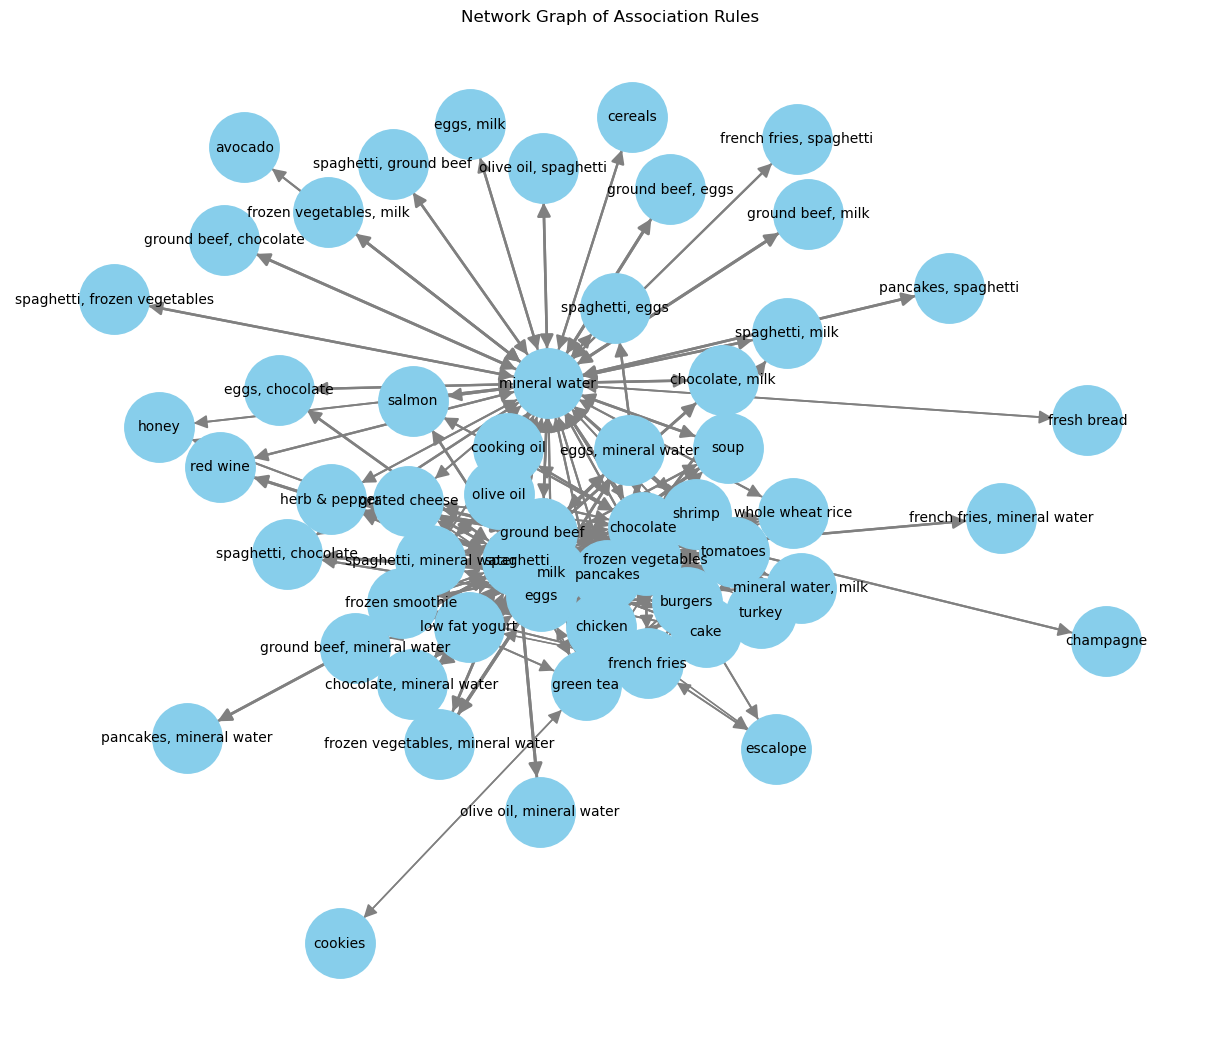

In [63]:
# Helper function to convert frozensets to strings for labeling
rules['antecedents_str'] = rules['antecedents'].apply(lambda x: ', '.join(list(x)))
rules['consequents_str'] = rules['consequents'].apply(lambda x: ', '.join(list(x)))

G = nx.DiGraph()

# Add edges using the converted strings
for i, row in rules.iterrows():
    # We use the string versions for the nodes/labels
    G.add_edge(row['antecedents_str'], row['consequents_str'], weight=row['lift'])

#  Plotting
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=0.5) # k adjusts the distance between nodes

# Draw the network
nx.draw(G, pos, with_labels=True, 
        node_size=2500, 
        node_color="skyblue", 
        font_size=10, 
        edge_color="gray",
        width=[G[u][v]['weight'] for u,v in G.edges()], # Line thickness based on Lift
        arrowsize=20)

plt.title("Network Graph of Association Rules")
plt.show()

## How to Interpret the Output:
Arrows: The arrow points from the item being bought first (Antecedent) to the item being bought next (Consequent).

Although, we have 100s of rules that makes our Network graph we can still find some insights

Support Analysis: Items like "mineral water" and "spaghetti" often have high support because they are staples.
The Power of Lift: Rules with a Lift > 1 indicate that the items are not just common, but actually depend on each other. 
For example, if $\{Herb \ \& \ Pepper\} \to \{Ground \ Beef\}$ has a high lift, it suggests a strong cooking-related association

#### Business Insight: High-confidence rules can be used for store layout optimization (placing associated items together) or bundle deals.

#### What is Lift and why is it important?
Lift measures how much more likely the consequent is to be bought given the antecedent, compared to its overall popularity. It is important because it filters out "coincidences" where an item is only frequently appearing because it's a popular staple (like water).

#### What are Support and Confidence? How do you calculate them?
###### Support: The % of total transactions containing the itemset. ($\text{Count}(A,B) / \text{Total Transactions}$).
###### Confidence: The probability that item B is purchased when item A is purchased. ($\text{Support}(A,B) / \text{Support}(A)$).

#### What are some limitations of Association Rule Mining?
It can be computationally expensive on massive datasets (though Apriori prunes the search space). It may also generate thousands of redundant rules if thresholds are set too low.

In [74]:
# appearing in at least 3% of transactions with Lift >=1.2

frequent_itemsets = apriori(df_encoded, min_support=0.03, use_colnames=True) 

# Generate rules with a minimum lift threshold
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)

# Sort rules by Lift to find the strongest relationships
rules.sort_values('lift', ascending=False)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
14,(spaghetti),(ground beef),0.174110,0.098254,0.039195,0.225115,2.291162,1.0,0.022088,1.163716,0.682343,0.168096,0.140684,0.312015
15,(ground beef),(spaghetti),0.098254,0.174110,0.039195,0.398915,2.291162,1.0,0.022088,1.373997,0.624943,0.168096,0.272197,0.312015
13,(mineral water),(ground beef),0.238368,0.098254,0.040928,0.171700,1.747522,1.0,0.017507,1.088672,0.561638,0.138413,0.081449,0.294127
12,(ground beef),(mineral water),0.098254,0.238368,0.040928,0.416554,1.747522,1.0,0.017507,1.305401,0.474369,0.138413,0.233952,0.294127
10,(frozen vegetables),(mineral water),0.095321,0.238368,0.035729,0.374825,1.572463,1.0,0.013007,1.218270,0.402413,0.119911,0.179164,0.262357
11,(mineral water),(frozen vegetables),0.238368,0.095321,0.035729,0.149888,1.572463,1.0,0.013007,1.064189,0.477993,0.119911,0.060317,0.262357
18,(spaghetti),(milk),0.174110,0.129583,0.035462,0.203675,1.571779,1.0,0.012900,1.093043,0.440468,0.132207,0.085123,0.238669
19,(milk),(spaghetti),0.129583,0.174110,0.035462,0.273663,1.571779,1.0,0.012900,1.137061,0.417935,0.132207,0.120540,0.238669
17,(mineral water),(milk),0.238368,0.129583,0.047994,0.201342,1.553774,1.0,0.017105,1.089850,0.467950,0.150000,0.082443,0.285856
16,(milk),(mineral water),0.129583,0.238368,0.047994,0.370370,1.553774,1.0,0.017105,1.209650,0.409465,0.150000,0.173315,0.285856


C:\Users\snjvm\anaconda3\Lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


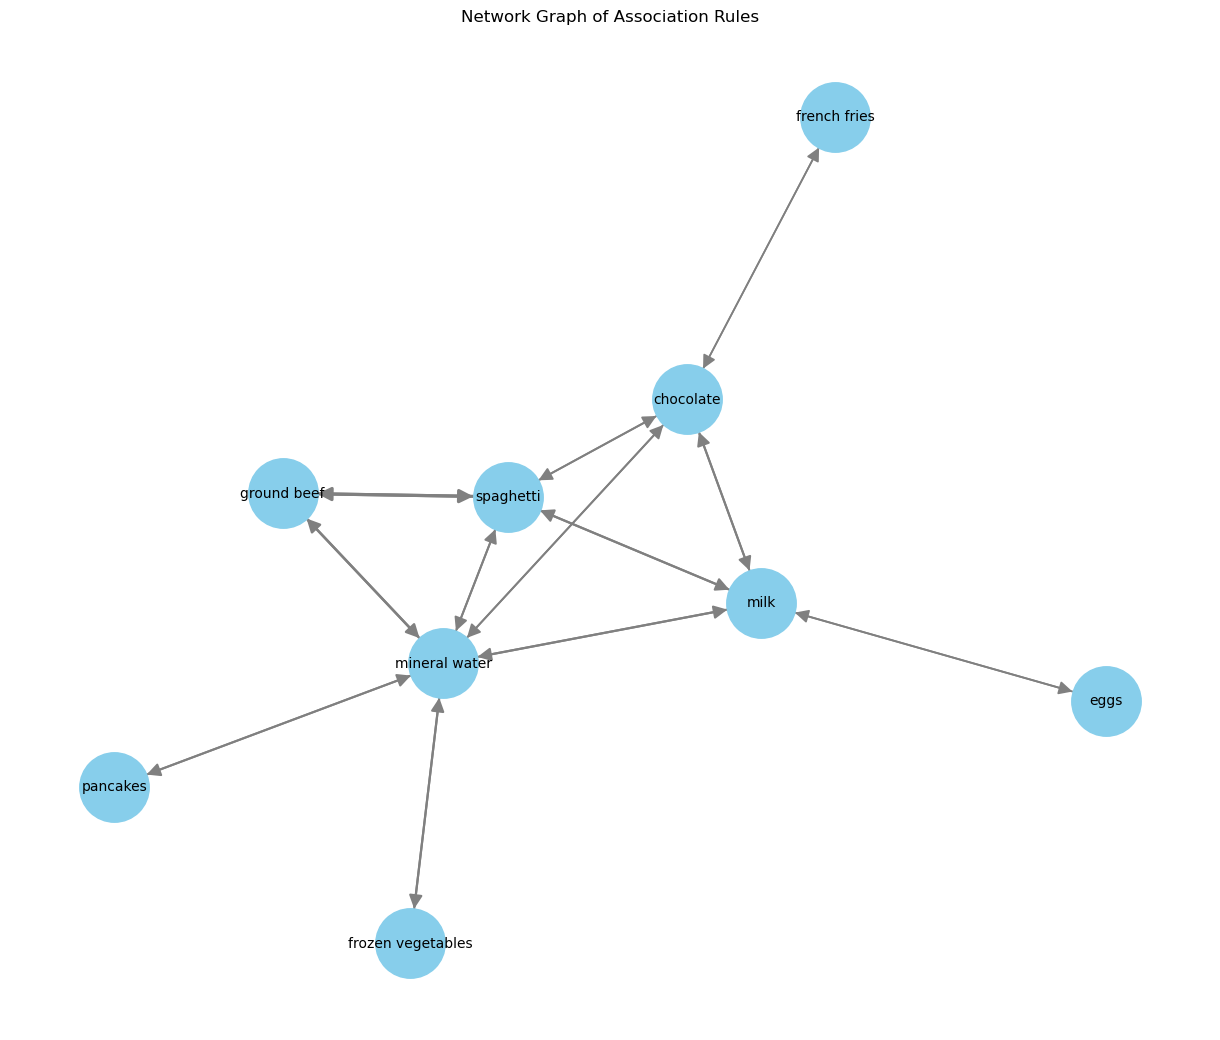

In [76]:
# Helper function to convert frozensets to strings for labeling
rules['antecedents_str'] = rules['antecedents'].apply(lambda x: ', '.join(list(x)))
rules['consequents_str'] = rules['consequents'].apply(lambda x: ', '.join(list(x)))

G = nx.DiGraph()

# Add edges using the converted strings
for i, row in rules.iterrows():
    # We use the string versions for the nodes/labels
    G.add_edge(row['antecedents_str'], row['consequents_str'], weight=row['lift'])

#  Plotting
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=0.5) # k adjusts the distance between nodes

# Draw the network
nx.draw(G, pos, with_labels=True, 
        node_size=2500, 
        node_color="skyblue", 
        font_size=10, 
        edge_color="gray",
        width=[G[u][v]['weight'] for u,v in G.edges()], # Line thickness based on Lift
        arrowsize=20)

plt.title("Network Graph of Association Rules")
plt.show()

The Previous Network graph was very messy and unclear but with parameters like 
min_support =3% and min_threshold = 1.5 we are getting a nice looking correlation network graph. It shows the relationship likelihood of being purchased very clearly 

In [79]:
# appearing in at least 5% of transactions with Lift >=1.1

frequent_itemsets = apriori(df_encoded, min_support=0.05, use_colnames=True) 

# Generate rules with a minimum lift threshold
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.1)

# Sort rules by Lift to find the strongest relationships
rules.sort_values('lift', ascending=False)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
4,(spaghetti),(mineral water),0.174110,0.238368,0.059725,0.343032,1.439085,1.0,0.018223,1.159314,0.369437,0.169312,0.137421,0.296796
5,(mineral water),(spaghetti),0.238368,0.174110,0.059725,0.250559,1.439085,1.0,0.018223,1.102008,0.400606,0.169312,0.092566,0.296796
0,(chocolate),(mineral water),0.163845,0.238368,0.052660,0.321400,1.348332,1.0,0.013604,1.122357,0.308965,0.150648,0.109018,0.271158
1,(mineral water),(chocolate),0.238368,0.163845,0.052660,0.220917,1.348332,1.0,0.013604,1.073256,0.339197,0.150648,0.068256,0.271158
2,(eggs),(mineral water),0.179709,0.238368,0.050927,0.283383,1.188845,1.0,0.008090,1.062815,0.193648,0.138707,0.059103,0.248515
3,(mineral water),(eggs),0.238368,0.179709,0.050927,0.213647,1.188845,1.0,0.008090,1.043158,0.208562,0.138707,0.041372,0.248515


C:\Users\snjvm\anaconda3\Lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


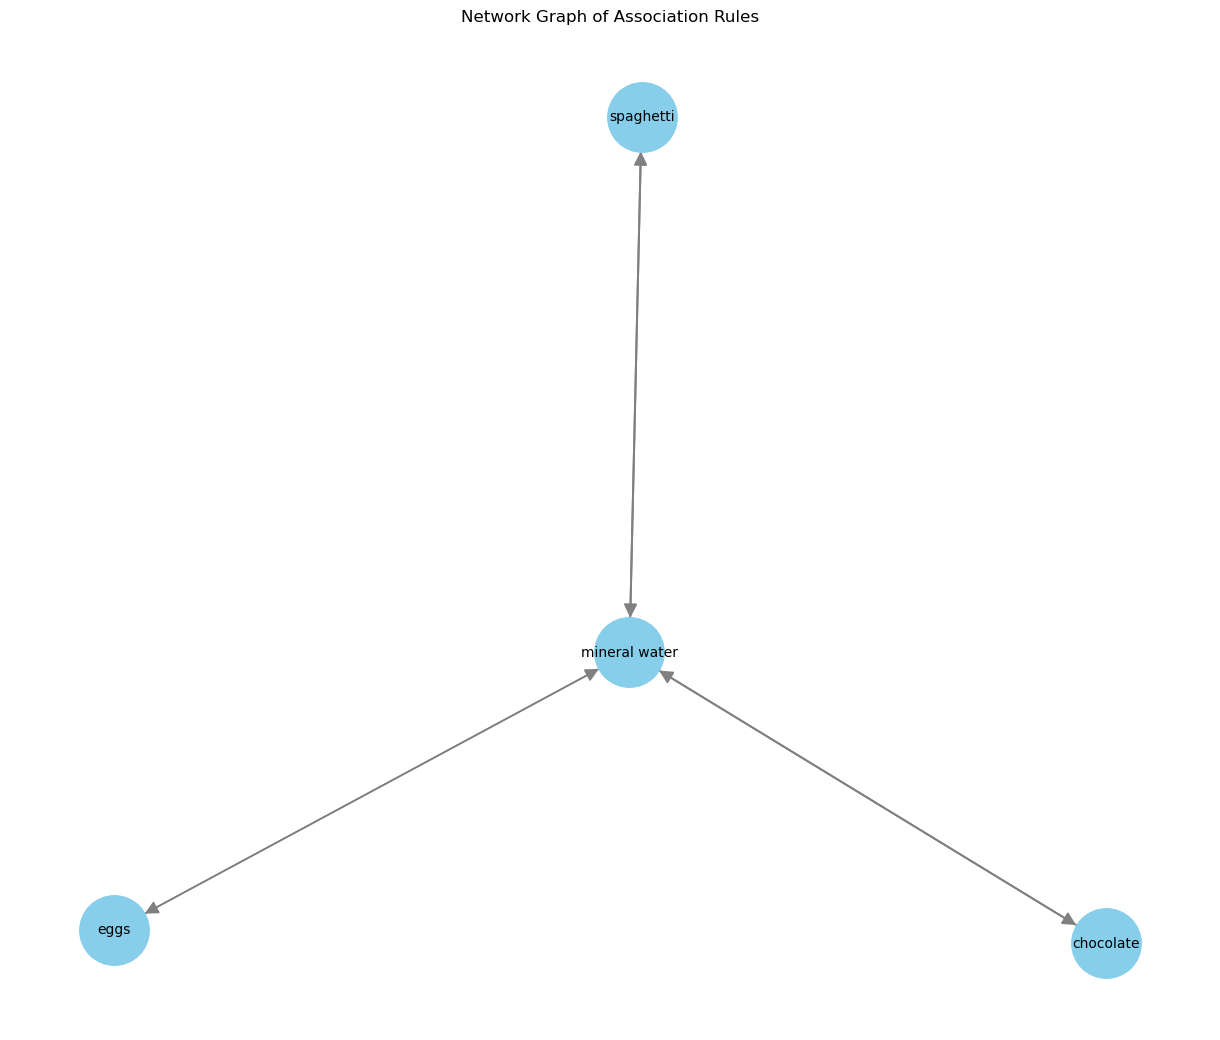

In [81]:
# Helper function to convert frozensets to strings for labeling
rules['antecedents_str'] = rules['antecedents'].apply(lambda x: ', '.join(list(x)))
rules['consequents_str'] = rules['consequents'].apply(lambda x: ', '.join(list(x)))

G = nx.DiGraph()

# Add edges using the converted strings
for i, row in rules.iterrows():
    # We use the string versions for the nodes/labels
    G.add_edge(row['antecedents_str'], row['consequents_str'], weight=row['lift'])

#  Plotting
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=0.5) # k adjusts the distance between nodes

# Draw the network
nx.draw(G, pos, with_labels=True, 
        node_size=2500, 
        node_color="skyblue", 
        font_size=10, 
        edge_color="gray",
        width=[G[u][v]['weight'] for u,v in G.edges()], # Line thickness based on Lift
        arrowsize=20)

plt.title("Network Graph of Association Rules")
plt.show()